In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

**Training on Moons Dataset**

Generating the moons dataset which a two intervening circles

In [3]:
from sklearn.datasets import make_moons

X,y = make_moons(n_samples = 10000, noise = 0.4, random_state = 42)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

params = {'max_leaf_nodes': list(range(2,100)), 'min_samples_split': [2,3,4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state = 42), params, verbose = 1, cv = 3)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 882 out of 882 | elapsed:    7.3s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,


In [8]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=17,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

Visualization of how Decision Tree classified

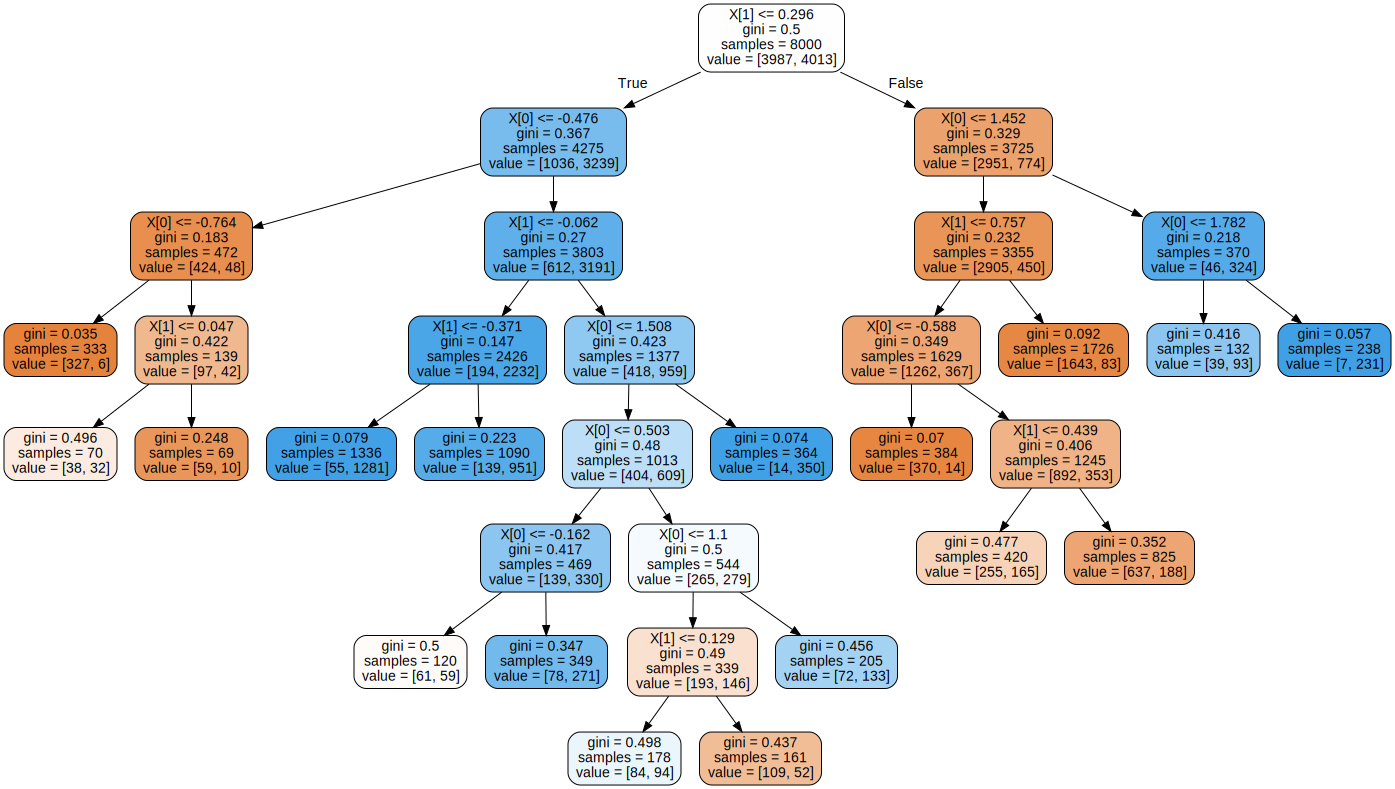

In [31]:
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        grid_search_cv.best_estimator_,
        out_file=os.path.join(IMAGES_PATH, "moons_tree.dot"),
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "moons_tree.dot"))

By default, GridSearchCV trains the best model found on the whole training set (on can change this by setting refit = False)

In [9]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8695

The result is not bad, but we can improve further by tweaking the hyperparameters

**Creating the Forest from the above classifier**

Generating 1,000 subsets of the training set, each containing 100 instances selected randomly from the created moons dataset.

In [20]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

#Yields indices to split the data into training and test sets
rs = ShuffleSplit(n_splits = n_trees, test_size = len(X_train) - n_instances, random_state = 42)

for mini_train_index, mini_test_index in rs.split(X_train):
    #The shape of the mini_train_index is 100*1 and The shape of the mini_test_index is 7900*1
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

Let's train the one decision tree on each subset with the best hyperparameter found in the above example.
Logically, we should get lesser accuracy than the previous decision tree classfier as we are training on lesser training instances.

In [21]:
from sklearn.base import clone

forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    
np.mean(accuracy_scores)

0.8054499999999999

For each test set instance, generate the predictions of the 1,000 Decision Trees, and keep only the most frequent prediction.i.e, majority vote predictions over the test set.

In [22]:
Y_pred = np.empty([n_trees, len(X_test)], dtype = np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [23]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis = 0)

In [24]:
y_pred_majority_votes

array([[1, 1, 0, ..., 0, 0, 0]], dtype=uint8)

In [25]:
n_votes

array([[951, 912, 963, ..., 919, 994, 602]])

In [27]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.872

Kudos! We trained the Random Forest Classifier